In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import pandas as pd
import numpy as np
import math

# Exploring
import scipy.stats as stats

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from env import get_db_url
import os
from itertools import combinations
# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format
from sklearn.model_selection import train_test_split
import wrangle_zillow as wrangle
import utilities
from sklearn.preprocessing import MinMaxScaler


# Zillow Regression Project

# Executive Summary

executive summary goes here

# The Gameplan:

- Attempt to explain what factors can be used to explain (and potentially lower) logerror:

- Acquire and prepare the data

- Explore the different factors that could contribute to logerror

- Try out a few different models

- Offer final recommendations

# Acquiring and Preparing the data

Talk about what the wrangle function does

In [2]:
# calling the wrangle function from the wrangle.py file
df = wrangle.wrangle_zillow()

In [4]:
# This function pulls from the wrangle.py file and splits the data into train, validate, and test
# This will be used in the exploration
train, validate, test = wrangle.split_zillow_data(df)

In [23]:
# we will go ahead and scale the data to use later on for the machine learning portion
columns_to_scale = df.select_dtypes('number').columns.drop(['propertylandusetypeid', 'fips', 'regionidcity', 'censustractandblock','id.1', 'latitude', 'longitude','regionidzip', 'logerror'])
train_s, validate_s, test_s = wrangle.data_scaled(train, validate, test, columns_to_scale)
train_s.shape, validate_s.shape, test_s.shape

((26026, 22), (11155, 22), (9296, 22))

# Exploration


The goal is to try to find drivers of log error and hopefully create a model to help predict log error

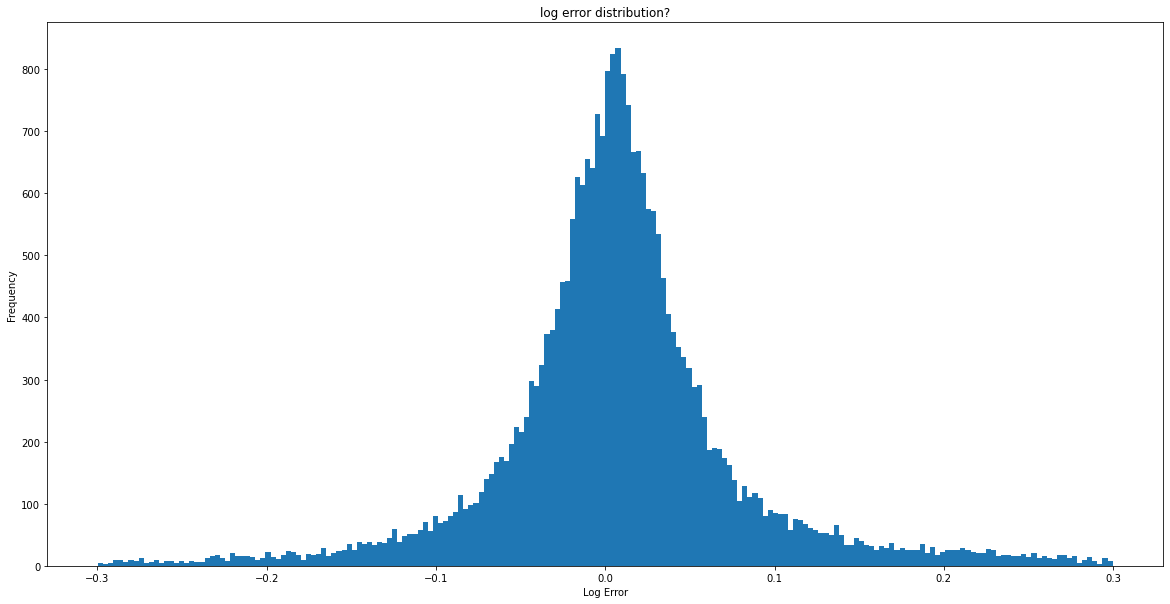

In [28]:
# First, lets see how the log error is distributed

plt.figure(figsize=(20,10))
plt.hist(train.logerror, bins=200)

plt.xlabel('Log Error')
plt.ylabel('Frequency')
plt.title('log error distribution?')
plt.show()

In [29]:
# Next, I want to see if there is anything that has a particularly strong relationship with log error
columns_corr = train.corr()
columns_corr.logerror

propertylandusetypeid                           NaN
bathroomcnt                                    0.06
bedroomcnt                                     0.06
calculatedfinishedsquarefeet                   0.07
fips                                           0.02
latitude                                      -0.02
longitude                                      0.01
lotsizesquarefeet                              0.00
regionidcity                                  -0.00
regionidzip                                    0.01
yearbuilt                                      0.04
taxvaluedollarcnt                              0.01
taxamount                                      0.01
censustractandblock                            0.02
id.1                                          -0.00
logerror                                       1.00
age                                           -0.04
month                                         -0.01
Name: logerror, dtype: float64

Takeaway : 

- the closer that a value is to one, the more similar it is to log error
    
- There doesn't seem to be anything that has a particularly strong relationship with log error right off the bat

### Question 1: Is there a difference in logerror between each of hte counties?

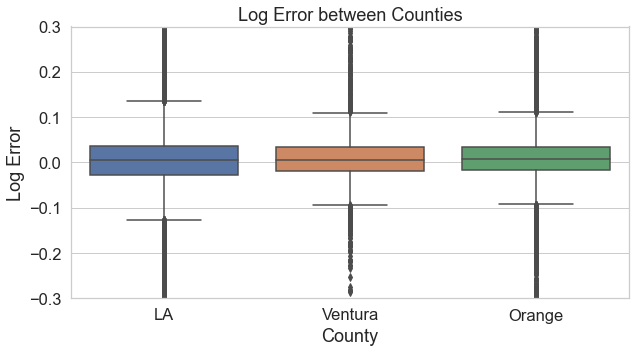

In [39]:
# plot out the log error between each of the counties
sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(10,5))
plt.ylim(-.3, .3) # Range of y-axis is trimmed to better visualize IQR
sns.boxplot(data=train, x=train.county, y=train.logerror)
plt.title('Log Error between Counties')
plt.xlabel('County')
plt.ylabel('Log Error')
plt.show()

- visually, it seems that the average log error is about the same between each county, but LA county does have a larger lower quartile

### We wil run an Anova test to see if there is a more meaningful difference in the means
H0: There is no difference between the average log error of these counties.

H1: There is a difference between the average log error of at least one of these counties. 

In [45]:
#one-way anova test 
alpha = 0.05
F, p = stats.f_oneway(train.logerror[train.county == 'LA'], train.logerror[train.county == 'Orange'], train.logerror[train.county == 'Ventura'])
F, p

(12.350793385182836, 4.351737907478078e-06)

In [46]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')


We reject the null hypothesis


In [51]:
# we will test the same null hypothesis using the Kruskal- Wallis test in case the data wasn't normally distributed
alpha = 0.05
H, p = stats.kruskal(train.logerror[train.county == 'LA'], train.logerror[train.county == 'Orange'], train.logerror[train.county == 'Ventura'])
H, p

(34.15811814394361, 3.825241765625664e-08)

In [50]:
if p < alpha:
    print('We reject the null hypothesis')
else:
    print('We fail to reject the null hypothesis')

We reject the null hypothesis


Takeaway: 
    While there doesn't seem to be a difference that we can see in our visualization, there is a statistical difference between the logerror of each county

# Question 2: Is there a relationship between log error and the month that the property was sold

In [117]:
# before getting started, lets see the number of sales per month
train.month.value_counts().sort_index()

1    2381
2    2079
3    3038
4    2968
5    3548
6    3894
7    3191
8    3387
9    1540
Name: month, dtype: int64

- we can see that more people are buying towards the middle of the year

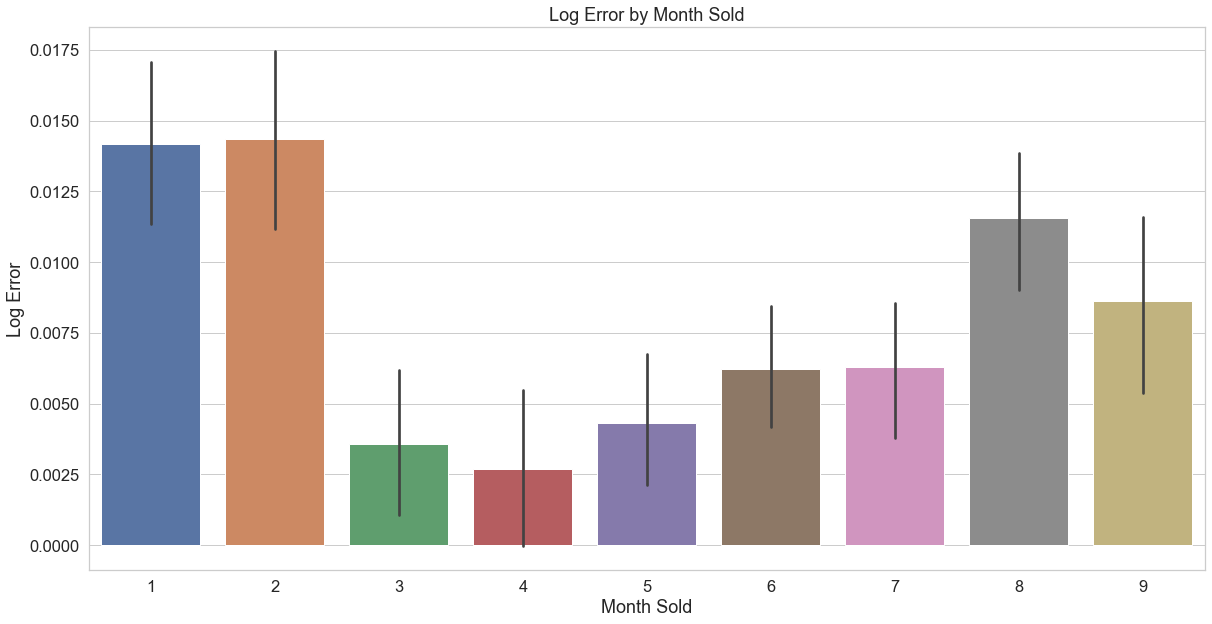

In [118]:
# Bar plot for month and log error
# further see if the relationship varies by county
plt.figure(figsize=(20,10))
sns.barplot(data=train, x=train.month, y= train.logerror)
plt.title('Log Error by Month Sold')
plt.xlabel('Month Sold')
plt.ylabel('Log Error')
plt.show()

- this plot, combined with the number of sales that we know from earlier, shows us that there could be a relationship between the number of sales made during a time frame and logerror.
- In the first, second, and nineth month, there were significantly less sales made and the logerror during those times seems, on average, to be a lot higher

## Question 3: Is there a relationship between tax assessed property values and log error? 

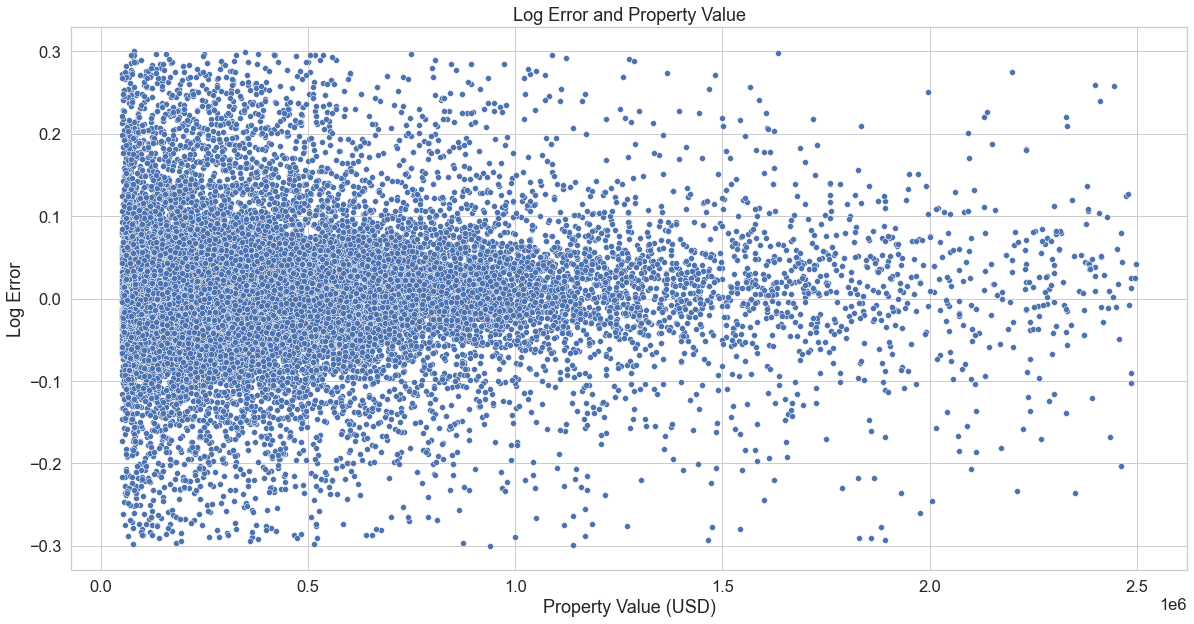

In [84]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=train, x=train.taxvaluedollarcnt, y= train.logerror)
plt.title('Log Error and Property Value')
plt.xlabel('Property Value (USD)')
plt.ylabel('Log Error')
plt.show()